In [1]:
#hopper.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#5 February 2018
#
#hopper uses Q-learning to teach a neural net AI to...

In [2]:
#game settings
max_moves = 1000
rn_seed = 14

In [3]:
#import the hopper game
from hopper import *
import time
time_start = time.time()

In [4]:
#import plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, font='DejaVu Sans')

In [5]:
#initialize system
N_moves = 1
environment = initialize_environment(rn_seed, max_moves)
state = initialize_state(environment)
reward = get_reward(state)
separation, angle = get_separation(state)
game_state = get_game_state(N_moves, environment)
print 'environment = ', environment
print 'state = ', state
print 'reward = ', reward
print 'separation = ', separation
print 'angle = ', angle
print 'game_state = ', game_state

environment =  {'max_moves': 1000, 'rn_seed': 14, 'acts': ['slow-left', 'slow-right', 'fast-left', 'fast-right'], 'actions': [0, 1, 2, 3]}
state =  {'cat_run_direction_angle': -1.1489507950969766, 'bug_direction_angle': -1.1489507950969766, 'bug_distance': 2.5771828788349493, 'bug': array([ 0.,  0.]), 'cat': array([-1.05521437,  2.35125376])}
reward =  0.385418084218
separation =  2.57718287883
angle =  -1.1489507951
game_state =  running


In [6]:
#play one game, slow cat
strategy = 'slow'
memories = play_game(environment, strategy)
cat, bug, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
cumulative_bug_distances = bug_distances.cumsum()
memories_slow = memories
print 'strategy = ', strategy
print 'max cumulative_rewards = ', cumulative_rewards.max()
print 'max cumulative_bug_distances = ', cumulative_bug_distances.max()

strategy =  slow
max cumulative_rewards =  712.03301762
max cumulative_bug_distances =  2671.31475455


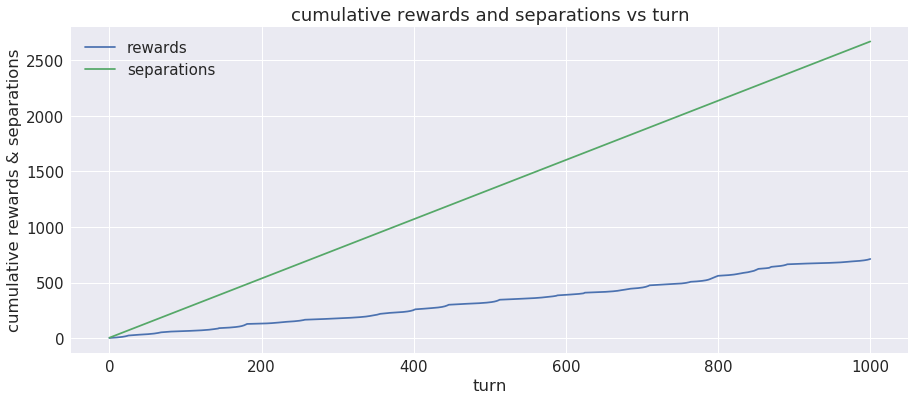

In [7]:
#plot cumulative rewards and separations vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp, label='rewards')
yp = cumulative_bug_distances
ax.plot(xp, yp, label='separations')
ax.set_title('cumulative rewards and separations vs turn')
ax.set_ylabel('cumulative rewards & separations')
ax.set_xlabel('turn')
plt.legend()
plt.savefig('figs/rewards.png')

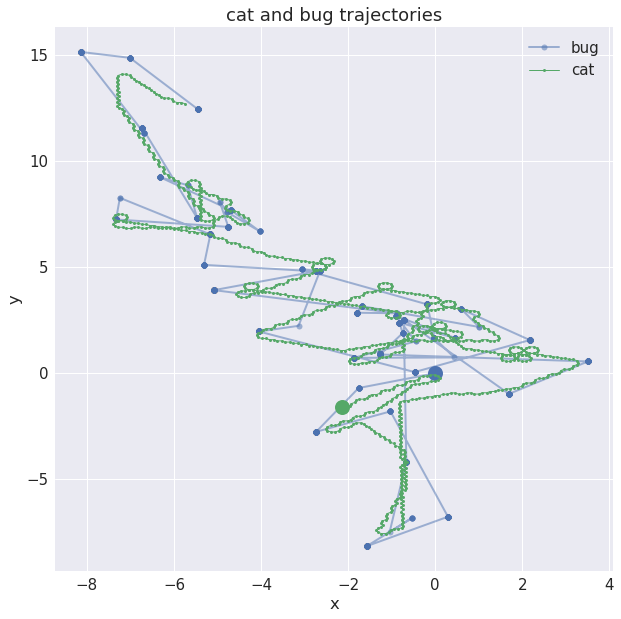

In [8]:
#plot cat and bug trajectories
fig, ax = plt.subplots(1,1, figsize=(10, 10))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()
plt.savefig('figs/xy.png')

In [9]:
#play one game, fast cat
strategy = 'fast'
memories = play_game(environment, strategy)
cat, bug, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
cumulative_bug_distances = bug_distances.cumsum()
memories_fast = memories
print 'strategy = ', strategy
print 'max cumulative_rewards = ', cumulative_rewards.max()
print 'max cumulative_bug_distances = ', cumulative_bug_distances.max()

strategy =  fast
max cumulative_rewards =  836.891364669
max cumulative_bug_distances =  3441.49188354


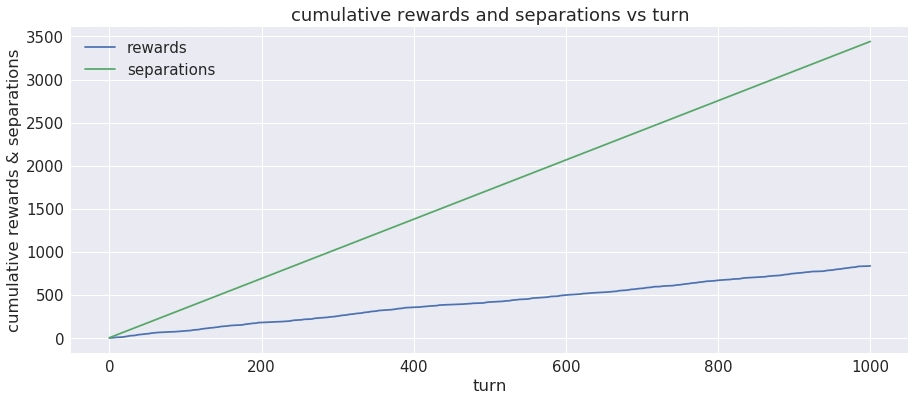

In [10]:
#plot cumulative rewards and separations vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp, label='rewards')
yp = cumulative_bug_distances
ax.plot(xp, yp, label='separations')
ax.set_title('cumulative rewards and separations vs turn')
ax.set_ylabel('cumulative rewards & separations')
ax.set_xlabel('turn')
plt.legend()

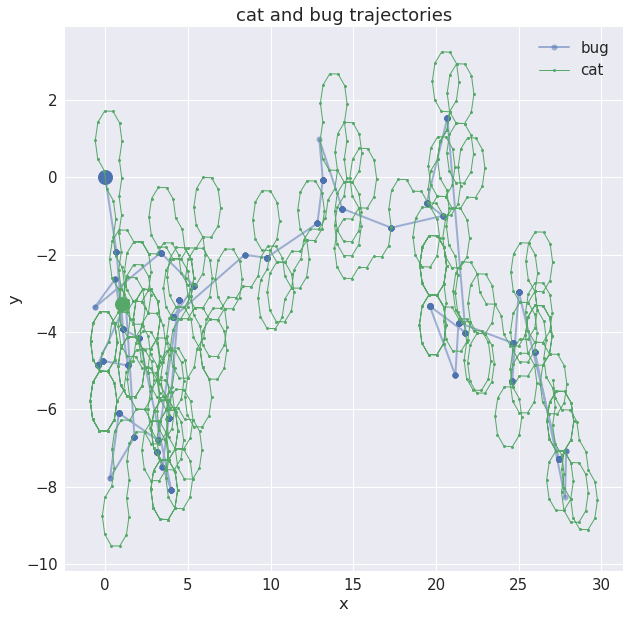

In [11]:
#plot cat and bug trajectories
fig, ax = plt.subplots(1,1, figsize=(10, 10))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

In [12]:
#use memories of previous runs, to initialize the training
memories = deque(maxlen=len(memories_slow) + len(memories_fast))
for memory in memories_slow:
    memories.append(memory)
for memory in memories_fast:
    memories.append(memory)
print 'number of memories = ', len(memories)

number of memories =  2002


In [ ]:
#build neural network model
state_vector = state2vector(state)
N_inputs = state_vector.shape[1]
N_outputs = len(environment['actions'])
N_neurons = 16
model = build_model(N_inputs, N_neurons, N_outputs)
print model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 404
Trainable params: 404
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Use Q-learning to train neural network to drive cat torwards bug..about two minutes to execute.
N_training_games = 100
gamma = 0.85                           #discount for future rewards
batch_size = len(memories)/20          #number of memories to use when fitting the model
debug = True
print 'training model...'
trained_model = train(environment, model, N_training_games, gamma, memories, batch_size, debug=debug)
print 'training done.'

training model...
game number =  0
move number =  1001
final action =  fast-left
final reward =  0.0329979937729
epsilon =  1.0
game_state =  max_moves
game number =  1
move number =  1001
final action =  slow-left
final reward =  0.020421882561
epsilon =  1.0
game_state =  max_moves
game number =  2
move number =  1001
final action =  fast-right
final reward =  0.102923592541
epsilon =  1.0
game_state =  max_moves
game number =  3
move number =  1001
final action =  fast-left
final reward =  0.0268631054822
epsilon =  1.0
game_state =  max_moves
game number =  4
move number =  1001
final action =  fast-right
final reward =  0.0195917661557
epsilon =  1.0
game_state =  max_moves
game number =  5
move number =  1001
final action =  slow-right
final reward =  0.0159490197437
epsilon =  1.0
game_state =  max_moves
game number =  6
move number =  1001
final action =  fast-right
final reward =  0.0346526265014
epsilon =  1.0
game_state =  max_moves
game number =  7
move number =  1001
final

In [ ]:
#done!
time_stop = time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0